Перед началом работы импортируем все необходимые библиотеки.

In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import  KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage
pd.set_option('display.max_columns', None)

Далее была создана функция, создающая данные.

In [74]:
def make_data(n, seed):
    np.random.seed(seed)
    shift_matrix = np.array([[3, 3],
    [6, 9],
    [9, 3]])
    data = np.random.randn(3, 2, n) + shift_matrix.reshape((3, 2, 1))
    data = np.swapaxes(data, 1, 2)
    data = data.reshape((-1, 2))
    data *= np.array([[20, 0.5]])
    df = pd.DataFrame({'x': data[:, 0], 'y': data[:, 1]},
    columns=['x', 'y'])
    df = df.sample(frac=1.0)
    return df

А также функция, создающая матрицу рассеяния вместе с раскрашенными кластерами и их центрами.

In [75]:
def scatter_cluster(k_pipeline, data, cluster, ax = None):
    n_clusters = max(cluster) + 1
    glue = data.copy(deep=True)
    glue['class'] = cluster
    centers = k_pipeline['scaler'].inverse_transform(k_pipeline['kmeans'].cluster_centers_)
    centers_np = np.hstack((centers, [[f'{i} center'] for i in range(n_clusters)]))
    glue = pd.concat([glue, pd.DataFrame(centers_np, columns=['x', 'y', 'class'])], axis = 0)
    sns.scatterplot(glue, x='x', y='y', hue='class', ax = ax)

Созданы данные, а также разделены на тренировочную и тестовую выборку. Затем данные были стандартизированы, а модель обучена на тренировочной выборке с числом кластеров равным трём.

In [76]:
train, test = make_data(80, 0), make_data(20, 0)
kmean_pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=3))]).fit(train)
kmean_train = kmean_pipeline.predict(train)
kmean_test = kmean_pipeline.predict(test)

Выведены графики с матрицами рассеяния для тренировочной и тестовой выборки. Модель Kmean успешно справилась с задачей кластеризации в обоих случаях.

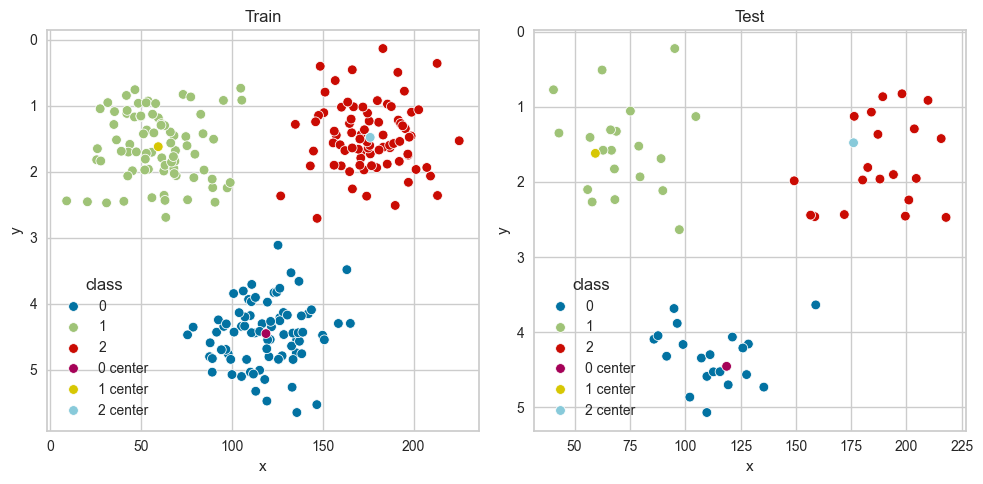

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
scatter_cluster(kmean_pipeline, train, kmean_train, axs[0])
scatter_cluster(kmean_pipeline, test, kmean_test, axs[1])
axs[0].set_title('Train')
axs[1].set_title('Test')
fig.tight_layout()

Далее выведен коэффициент силуэта, показывающий качество кластеризации. Коэффицент не сильно отличается в тестовой и тренировочной выборках, следовательно, переобучения не наблюдается.

In [ ]:
print(f'silhouette_train: {silhouette_score(train, kmean_train)},
       silhouette_test: {silhouette_score(test, kmean_test)}')

silhouette_train: 0.5194957458364139, silhouette_test: 0.4947239585679863


Далее аналогичным образом была обучена модель KMeans, но в этот раз количество кластеров было указано равным четырём.

In [ ]:
kmean_pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                                  ('kmeans', KMeans(n_clusters=4))]).fit(train)
kmean_train = kmean_pipeline.predict(train)
kmean_test = kmean_pipeline.predict(test)

Выведены графики рассеяния для четырёх кластеров. Можно сказать, что новый, четвёртый кластер не несёт никакой дополнительной информации. Также, два соседствующих кластера на тестовой выборке имеют сомнительную ценность.

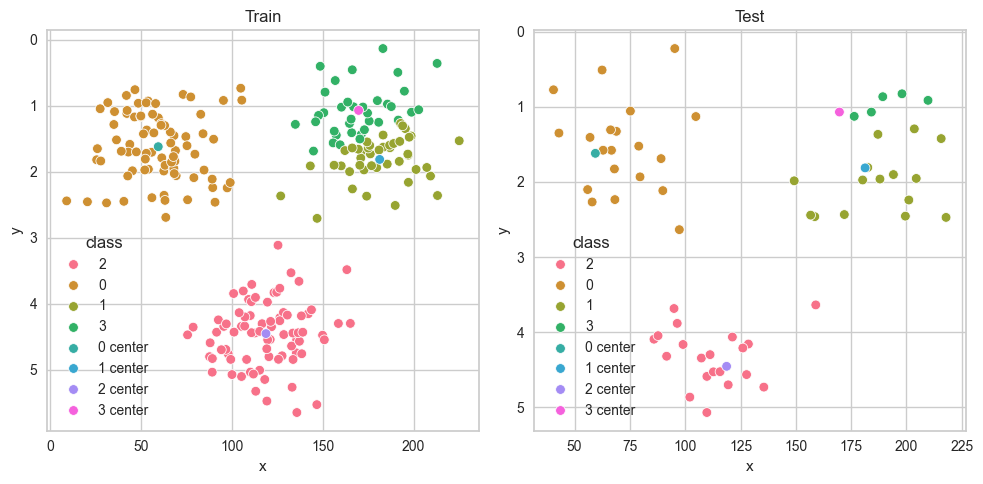

In [80]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
scatter_cluster(kmean_pipeline, train, kmean_train, axs[0])
scatter_cluster(kmean_pipeline, test, kmean_test, axs[1])
axs[0].set_title('Train')
axs[1].set_title('Test')
fig.tight_layout()

В этот раз коэффициент силуэта меньше, разница между тренировочной и тестовой выборкой более существенна, что может говорить о переобучении.

In [ ]:
print(f'silhouette_train: {silhouette_score(train, kmean_train)},
       silhouette_test: {silhouette_score(test, kmean_test)}')

silhouette_train: 0.33480351243153167, silhouette_test: 0.2196654494548457


Далее аналогичным образом была обучена модель KMeans, но в этот раз количество кластеров было указано равным двум.

In [ ]:
kmean_pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                                  ('kmeans', KMeans(n_clusters=2))]).fit(train)
kmean_train = kmean_pipeline.predict(train)
kmean_test = kmean_pipeline.predict(test)

Выведены графики рассеяния для двух кластеров. В этот раз центр 0 кластера находится очень далеко от своих точек. Точно так же, расстояние между точками 0 кластера очень велико. Однако на тестовой выборке модель показала себя точно так же хорошо, как и на тренировочной и правильно произвела кластеризацию.

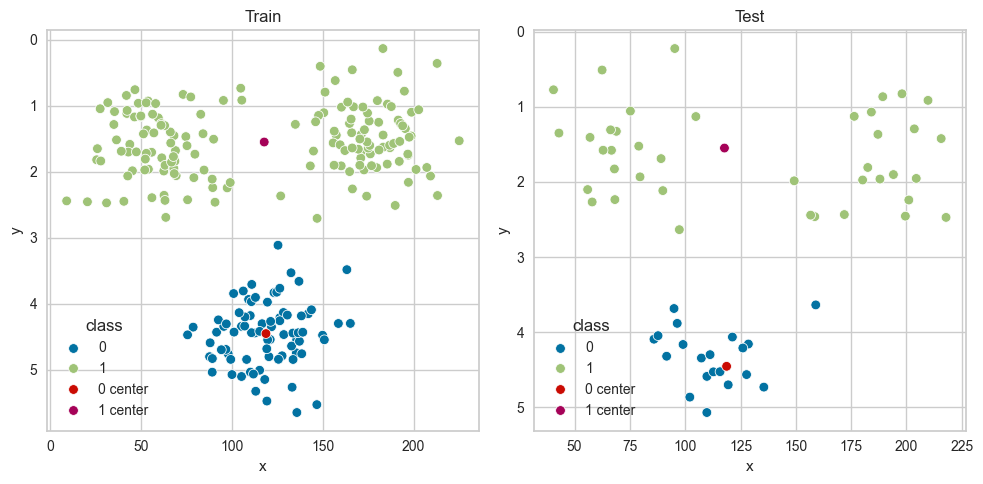

In [83]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
scatter_cluster(kmean_pipeline, train, kmean_train, axs[0])
scatter_cluster(kmean_pipeline, test, kmean_test, axs[1])
axs[0].set_title('Train')
axs[1].set_title('Test')
fig.tight_layout()

В случае с двумя кластерами коэффициент силуета очень низкий, так как расстояние между точками внутри кластеров в среднем увеличилось, а среднее расстояние от объектов одного кластера до другого не изменилось. 

In [ ]:
print(f'silhouette_train: {silhouette_score(train, kmean_train)}, 
      silhouette_test: {silhouette_score(test, kmean_test)}')

silhouette_train: 0.09121895497314823, silhouette_test: 0.0944414117129592


Далее был использован метод локтя для опреления оптимального количества кластеров. Как и ожидалось, рекомендованное число кластеров равно трём.

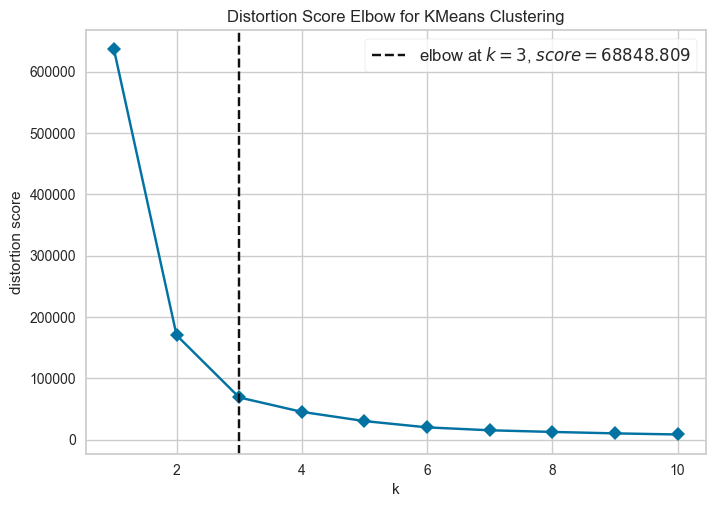

In [85]:
KElbowVisualizer(KMeans(), k=(1, 11), timings=False).fit(train).show()
plt.show()

Далее был загружен набор данных соответствующий первому варианту.
Датасет одержит информацию о сердечных болезнях
1. возраст
2. пол
3. тип боли в груди:(4 значения [TA: типичная стенокардия, ATA: атипичная стенокардия, NAP:
неангинальная боль, ASY: бессимптомная])
4. артериальное давление в покое
5. холестерин сыворотки в мг/дл
6. уровень сахара в крови натощак > 120 мг/дл
7. ЭКГ в покое: результаты электрокардиограммы в покое (норма: нормальная, ST: аномалия LVH: гипертрофия)
8. MaxHR максимальная достигнутая частота сердечных сокращений (Числовое значение от 60 до 202)
9. стенокардия, вызванная физической нагрузкой (да, нет)
10. oldpeak = депрессия ST, вызванная физической нагрузкой, по сравнению с состоянием покоя
11. наклон пикового сегмента ST при нагрузке Вверх: восходящий, Плоский: плоский, Вниз: нисходящий)
12. HeartDisease: выходной класс [1: болезнь сердца, 0: нормальный]

In [86]:
df = pd.read_csv('1heart.csv')
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140.0,289,0,Normal,172.0,N,0.0,Up,0
1,49,F,NAP,160.0,180,0,Normal,156.0,N,1.0,Flat,1
2,37,M,ATA,130.0,283,0,ST,98.0,N,0.0,Up,0
3,48,F,ASY,138.0,214,0,Normal,108.0,Y,1.5,Flat,1
4,54,M,NAP,150.0,195,0,Normal,122.0,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
920,38,M,NAP,138.0,175,0,Normal,173.0,N,0.0,Up,0
921,38,M,NAP,138.0,175,0,NaN,173.0,N,0.0,Up,0
922,57,F,ASY,140.0,a241,0,Normal,123.0,Y,0.2,Flat,1
923,55,F,ATA,132.0,342,0,Normal,NaN,N,1.2,Up,0


Далее была произведена предобработка данных.

Уровень холестерина имеет неправильный тип данных, имеются единичные пропуски в переменных: Cholesterol, RestingBP, RestingECG, MaxHR.

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             925 non-null    int64  
 1   Sex             925 non-null    object 
 2   ChestPainType   925 non-null    object 
 3   RestingBP       923 non-null    float64
 4   Cholesterol     924 non-null    object 
 5   FastingBS       925 non-null    int64  
 6   RestingECG      924 non-null    object 
 7   MaxHR           924 non-null    float64
 8   ExerciseAngina  925 non-null    object 
 9   Oldpeak         925 non-null    float64
 10  ST_Slope        925 non-null    object 
 11  HeartDisease    925 non-null    int64  
dtypes: float64(3), int64(3), object(6)
memory usage: 86.8+ KB


Выведены уникальные значение в каждом из столбцов, чтобы избавиться от ошибок в данных. 
- В столбце Sex некоторые переменные были названы 'Ma', они были заменены на 'M'.
- Последний элемент в столбце Cholesterol на рисунке ниже равен 'a241', что можно интерпретировать как ошибка при вводе данных. Следовательно, он был заменён на 241, а столбец приведён к численному типу данных.
- В столбце Oldpeak были негативные значения, чего быть не может. Эти значения были заменены на положительные.
- В столбце ST_Slope некоторые переменные были названы 'UP', они были заменены на 'Up'.

In [88]:
for column in df.columns:
    print(df[column].unique(), column, '\n')

[40 49 37 48 54 39 45 58 42 38 43 60 36 44 53 52 51 56 41 32 65 35 59 50
 47 31 46 57 55 63 66 34 33 61 29 62 28 30 74 68 72 64 69 67 73 70 77 75
 76 71] Age 

['M' 'F' 'Ma'] Sex 

['ATA' 'NAP' 'ASY' 'TA'] ChestPainType 

[140. 160. 130. 138. 150. 120. 110. 136. 115.  nan 100. 124. 113. 125.
 145. 112. 132. 118. 170. 142. 190. 135. 180. 108. 155. 128. 106.  92.
 200. 122.  98. 105. 133.  95.  80. 137. 185. 165. 126. 152. 116.   0.
 144. 154. 134. 104. 139. 131. 141. 178. 146. 158. 123. 102.  96. 143.
 172. 156. 114. 127. 101. 174.  94. 148. 117. 192. 129. 164.] RestingBP 

['289' '180' '283' '214' '195' '339' '237' '208' '207' '284' '211' '164'
 '204' '234' '273' '196' nan '248' '267' '223' '184' '201' '288' '215'
 '209' '260' '468' '188' '518' '167' '224' '172' '186' '254' '306' '250'
 '177' '227' '230' '294' '264' '259' '175' '318' '216' '340' '233' '205'
 '245' '194' '270' '213' '365' '342' '253' '277' '202' '297' '225' '246'
 '412' '265' '182' '218' '268' '163' '529' '100' '206' '2

In [89]:
df.loc[df['Cholesterol'] == 'a241', 'Cholesterol'] = 241
df['Cholesterol'] = df['Cholesterol'].astype('float')
df.loc[df['Sex'] == 'Ma', 'Sex'] = 'M'
df['Oldpeak'] = df['Oldpeak'].apply(abs)
df.loc[df['ST_Slope'] == 'UP', 'ST_Slope'] = 'Up'

Перед заполнением пропусков необходимо рассмотреть выбросы с помощью рисунка ниже.
- RestingBP в теории, может принимать значение 200, но точно не может принимать значение 0.
- Аналогично с Cholesterol.
- Oldpeak, в теории, может принимать большие значения

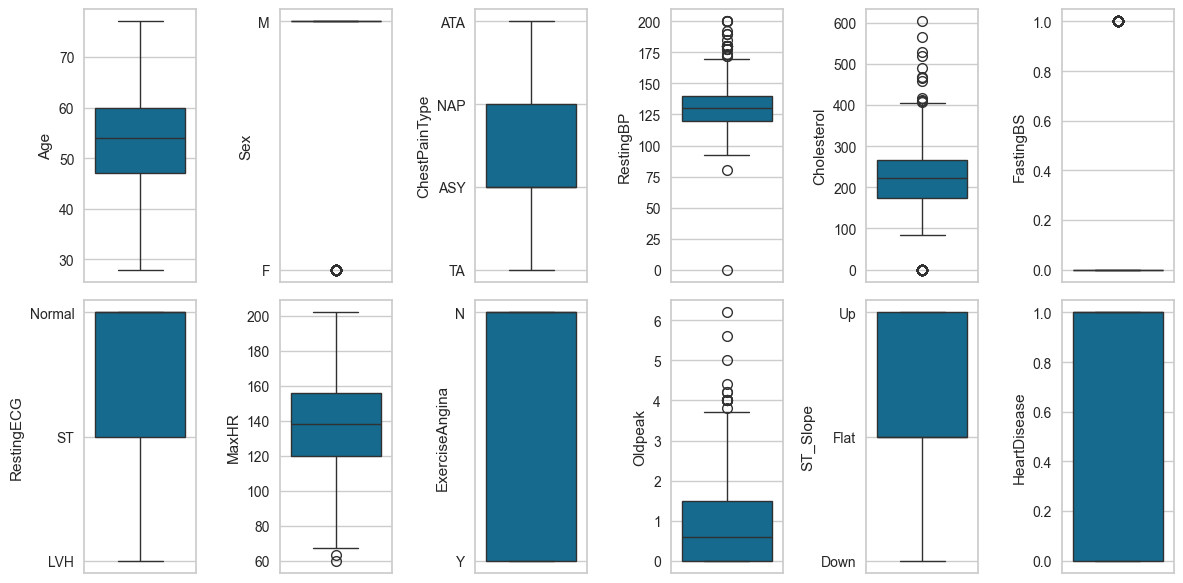

In [90]:
fig, axs = plt.subplots(2, 6, figsize=(12, 6))
for ax, column in zip(axs.reshape(-1), df.columns):
    sns.boxplot(df, y=column, ax=ax, legend=False)
fig.tight_layout()

Как показано ниже, выбросы влияют на целевую переменную. Поэтому было принято решение удалить только очевидные ошибки в данных, где уровень холестерина и давление равняются 0, а остальные выбросы оставить.

In [91]:
print(
df[df['Oldpeak'] > 4]['HeartDisease'].mean(),
df[df['RestingBP'] > 180]['HeartDisease'].mean(),
df[df['Cholesterol'] > 400]['HeartDisease'].mean(),
df[df['MaxHR'] < 70]['HeartDisease'].mean())

0.8333333333333334 0.875 0.6153846153846154 0.75


In [92]:
df = df[df['Cholesterol'] > 10]
df = df[df['RestingBP'] > 10]

Выведены пропуски в данных. Как видно из рисунка ниже, их достаточно мало (<10%) и в датасете нет большого количества выбросов(см. ниже), поэтому можем пропуски средним значением в числовых пропусках и модой в категориальных.

In [93]:
df[df.isna().any(axis=1)]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
921,38,M,NAP,138.0,175.0,0,NaN,173.0,N,0.0,Up,0
923,55,F,ATA,132.0,342.0,0,Normal,NaN,N,1.2,Up,0


In [94]:
for column in df.columns:
    if df[column].dtype == 'O':
        df[column] = df[column].fillna(df[column].mode()[0])
    else:
        df[column] = df[column].fillna(df[column].mean())

Далее была произведена one-hot кодировка категориальных данных. Выбор кодировки основан на том, что в датасете нет категориальных признаков с большим количеством уникальных значений, а там, где их больше 2-ух, нельзя установить их чёткий порядок.

In [95]:
df_encoded = pd.get_dummies(df)
df_encoded

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140.0,289.0,0,172.000000,0.0,0,False,True,False,True,False,False,False,True,False,True,False,False,False,True
1,49,160.0,180.0,0,156.000000,1.0,1,True,False,False,False,True,False,False,True,False,True,False,False,True,False
2,37,130.0,283.0,0,98.000000,0.0,0,False,True,False,True,False,False,False,False,True,True,False,False,False,True
3,48,138.0,214.0,0,108.000000,1.5,1,True,False,True,False,False,False,False,True,False,False,True,False,True,False
4,54,150.0,195.0,0,122.000000,0.0,0,False,True,False,False,True,False,False,True,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920,38,138.0,175.0,0,173.000000,0.0,0,False,True,False,False,True,False,False,True,False,True,False,False,False,True
921,38,138.0,175.0,0,173.000000,0.0,0,False,True,False,False,True,False,False,True,False,True,False,False,False,True
922,57,140.0,241.0,0,123.000000,0.2,1,True,False,True,False,False,False,False,True,False,False,True,False,True,False
923,55,132.0,342.0,0,140.378667,1.2,0,True,False,False,True,False,False,False,True,False,True,False,False,False,True


Далее было произведено разделение на целевую и независимые переменные. Целевая переменная - HeartDisease, она не будет использоваться при обучении.

In [96]:
X = df_encoded.drop('HeartDisease', axis=1)
y = df_encoded['HeartDisease']

Была построена матрица диаграмм рассеяния, которая показывает, что при увеличение возраста и депрессии ST, уменьшении максимальной частоты сердцебиения увеличивается шанс сердечных заболеваний.

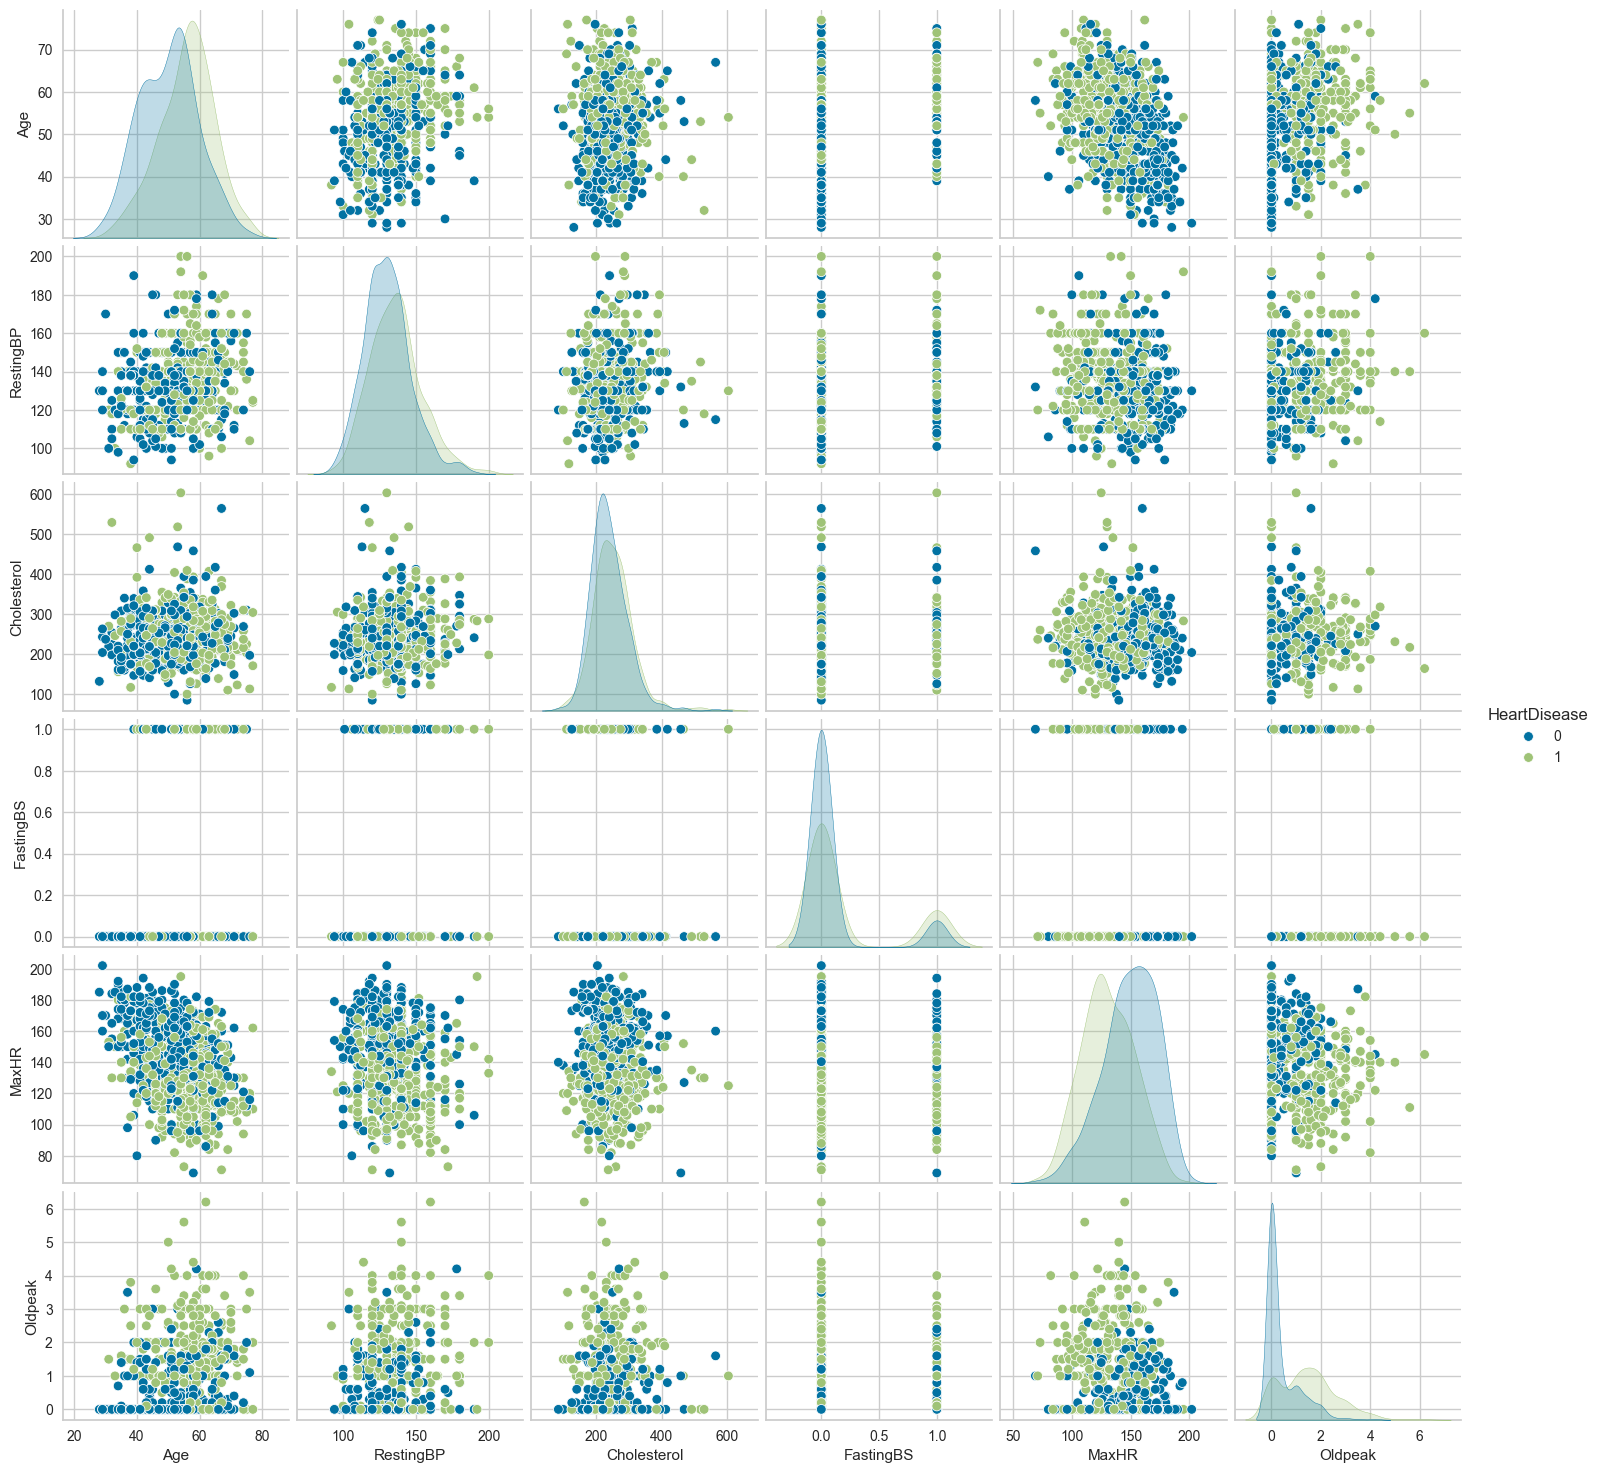

In [97]:
sns.pairplot(df, hue = 'HeartDisease')

Метод локтя, как показывает рисунок ниже, показывает, что оптимальное число кластеров равно трём, так как после этого distortion score замедляет своё уменьшение.

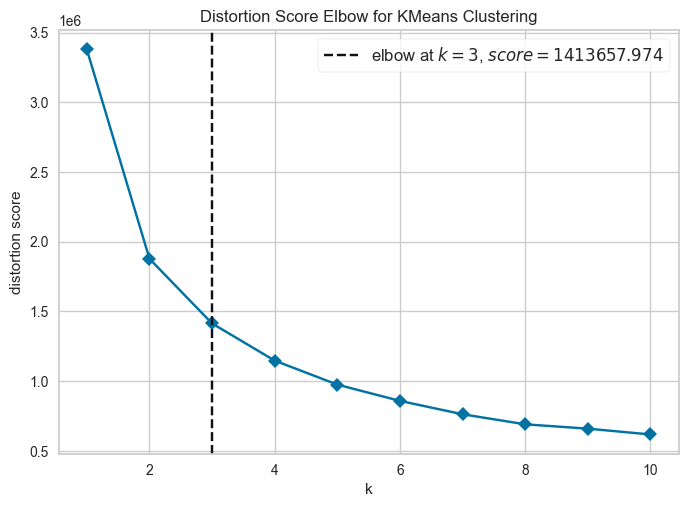

In [98]:
KElbowVisualizer(KMeans(), k=(1, 11), timings=False).fit(X).show()
plt.show()

Однако Silhouette score показывает, что наилучшее число кластеров равно двум, так как при этом достигается наилучший счёт. К тому же появляется кластер очень маленького размера, что не очень хорошо.

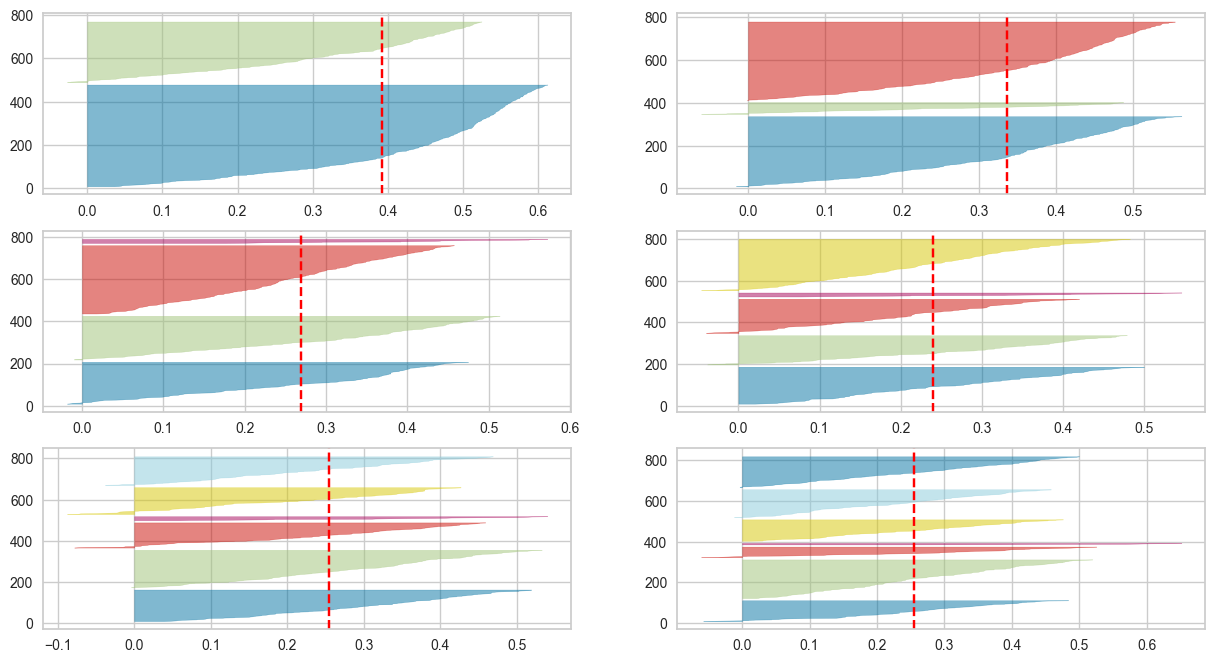

In [99]:
fig, axs = plt.subplots(3, 2, figsize=(15,8))
for i, ax in zip((2, 3, 4, 5, 6, 7), axs.reshape(-1)):
    km = KMeans(i)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax)
    visualizer.fit(X)

Дополнительно выполним кластеризацию иерархическим агломеративным методом для определения оптимального количества кластеров. Из диаграммы ниже можно сделать вывод, что оптимальное число кластеров равно двум, так как самое большое расстояние между кластерами будет достигаться именно при таком их числе. Также это соответствует нашей задаче по разделению людей на имеющих и не имеющих сердечные заболевания.

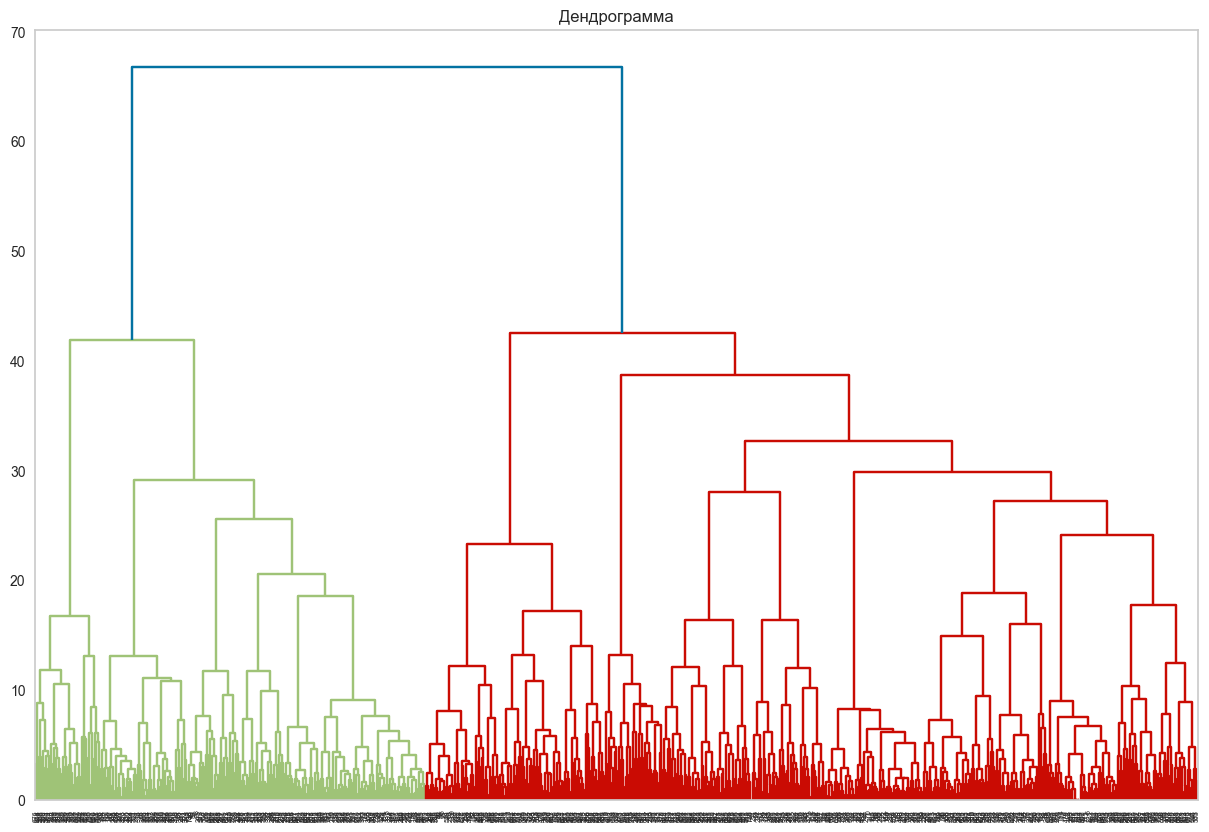

In [100]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)
linked = linkage(X_sc, method = 'ward')# таблица «связок» между объектами
# Визуализация дендрограммы
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.grid(False)
plt.title('Дендрограмма')
plt.show()

Далее была произведена кластеризация методом Kmeans с числом кластеров равным двум, а также подсчитаны средние показатели переменных внутри кластеров.

In [101]:
pipe_kmean = Pipeline((('stdscaler', StandardScaler()), ('kmeans', KMeans(2)))).fit(X)
cluster = pipe_kmean.predict(X)
df_clustered = X.copy(deep=True)
df_clustered['cluster'] = cluster
df_clustered['HeartDisease'] = y
df_clustered.groupby('cluster').mean()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,HeartDisease
cluster,,,,,,,,,,,,,,,,,,,,,
0,56.485632,136.833333,251.327586,0.235632,126.847701,1.552586,0.135057,0.864943,0.833333,0.034483,0.100575,0.031609,0.264368,0.517241,0.218391,0.215517,0.784483,0.103448,0.813218,0.083333,0.859195
1,49.702233,129.828784,238.521092,0.106700,152.062974,0.332258,0.337469,0.662531,0.200993,0.384615,0.339950,0.074442,0.210918,0.667494,0.121588,0.962779,0.037221,0.017370,0.178660,0.803970,0.143921


А также была произведена визуализация числовых показателей переменных в кластерах, из которой можно сделать следующие выводы.
- Шанс появления сердечных заболеваний резко увеличивается:
    - С возрастом
    - Значительно с увеличением депрессии ST
    - При наличии стенокардии после физических нагрузок
    - При плоском наклоне пикового сегмента ST
    - C уменьшением максимальной частоты сердцебиения
    - При бессимптомной боли в груди
- Шанс отсутствия сердечных заболеваний резко уменьшается:
    - Все факты противоположные обозначеным выше
    - При наклоне пикового сегмента ST вверх

Также есть менее важные факторы: уровень сахара в крови и частота сердцебиения в покое. 

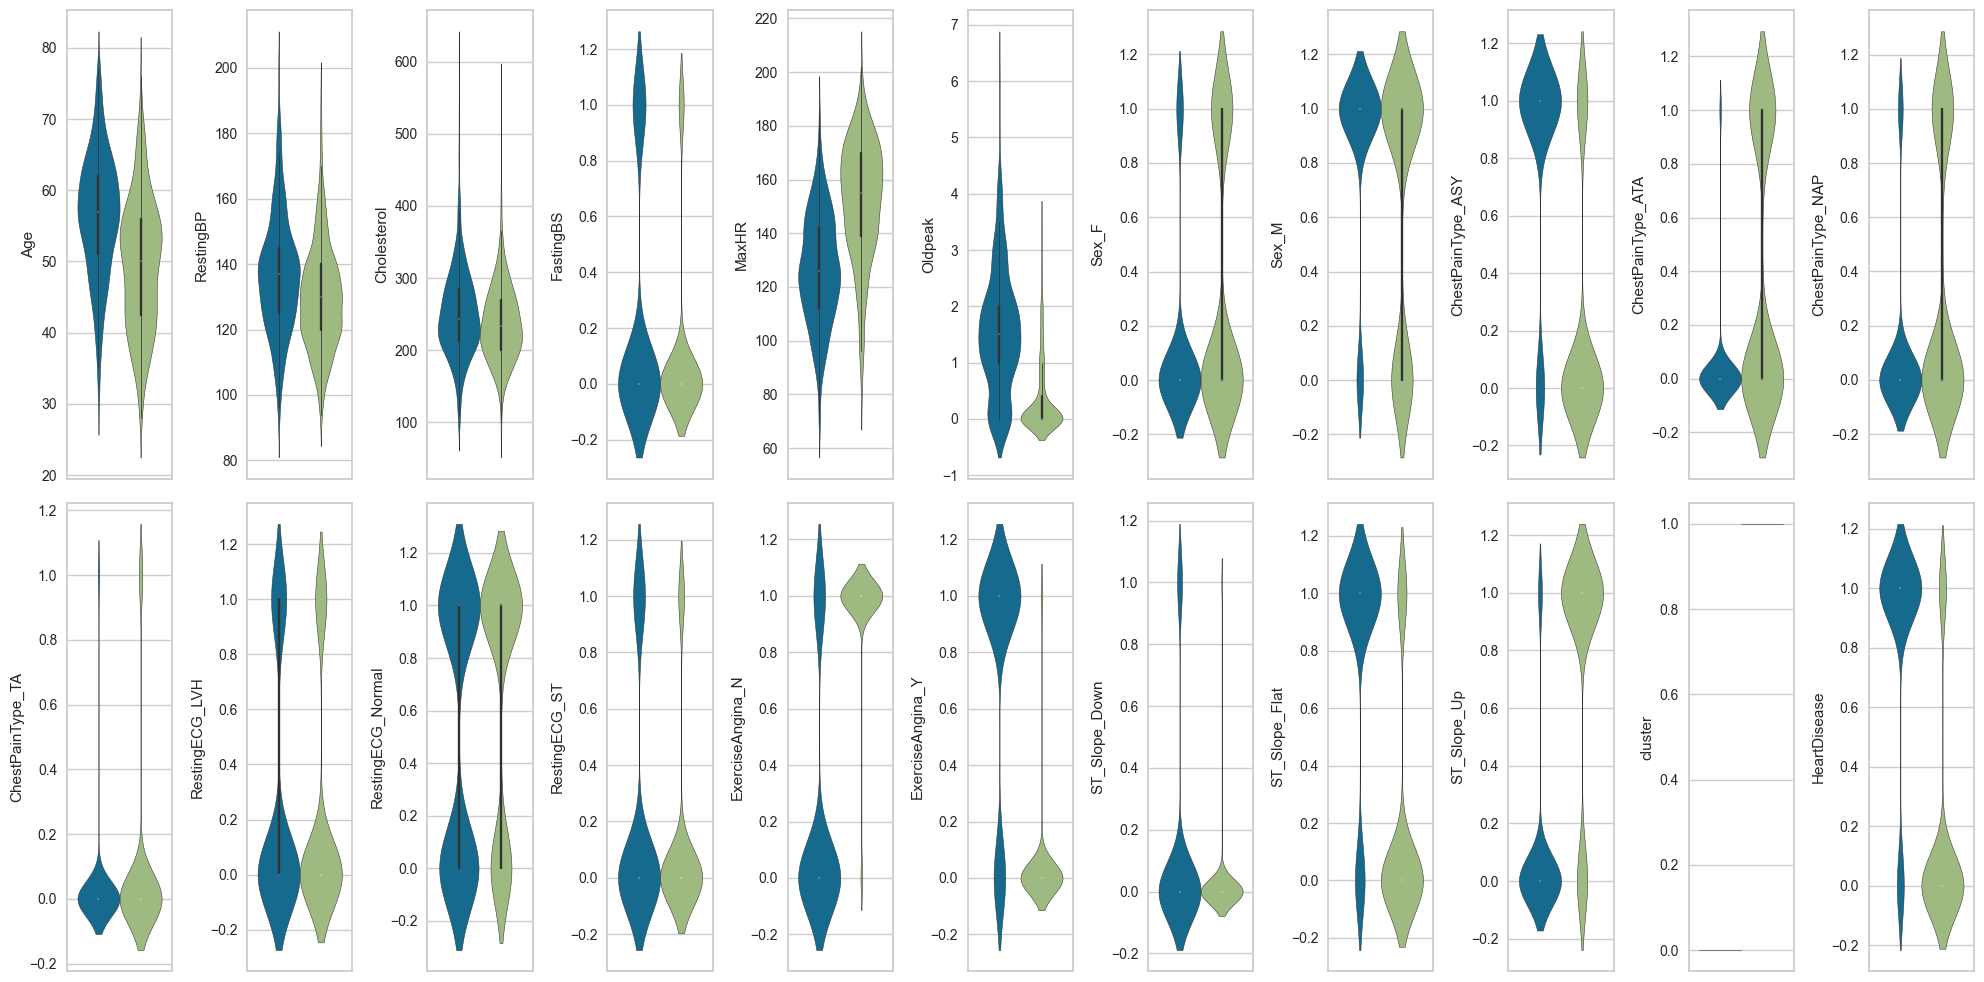

In [102]:
fig, axs = plt.subplots(2, 11, figsize=(20, 10))
for ax, column in zip(axs.reshape(-1), df_clustered.columns):
    sns.violinplot(df_clustered, y=column, ax=ax, hue='cluster', legend=False)
fig.tight_layout()

Вывод:
- В ходе работы была произведена кластеризация на искусственно созданных данных, где изначально задано три кластера. После этого опытным путём, с помощью построения диаграмм рассеяния и коэффициента силуэта было показано, что оптимальное число кластеров равно трём(ага). После это было дополнительно подтверждено с помощью метода локтя.
- Далее была выполнена кластеризация по датасету с информацией о сердечных болезнях.
- Данные были предобработаны: были исправлены ошибки в типах данных и названиях категорий, удалены выбросы и заполнены пропуски.
- Для категориальных данных была выполнена one-hot кодировка для того, чтобы не упустить важную информацию в тех категориях, где нет чёткой иерархии.
- Перед кластериацией было определено оптимальное число кластеров с помощью метода локтя, коэффициента силуэта, иерархического конгламеративного метода. Оптимальное число оказалось равным двум, что соответствует здравому смыслу - мы должны определить наличие или отсутствие сердечных заболеваний.
- Затем была произведена кластеризация, в ходе которой были выявлены факторы, влияющие в разной степени на шанс появления сердечных заболеваний. Из наиболее влиятельных факторов: большое значение депрессии ST, наличии стенокардии после физических нагрузок, плоский наклон пикового сегмента ST, малая максимальная частота сердцебиения, бессимптомная боль в груди.